In [52]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import optimization as op
from tqdm import tqdm

In [2]:
def softmax(v, temp=1.):
    sm = nn.Softmax(dim=0)
    return sm(v / temp)

In [55]:
def classify(x, phi, temp=0.02):
    return softmax( phi @ x , temp=temp)

def cost(x, x_hat):
    return torch.norm(x - x_hat) ** 2

def agent_reward(u, phi, x, x_hat, temp):
    return u @ classify(x_hat, phi, temp=temp) - cost(x, x_hat)

def gragent(X, phi, u, temp=0.02, attempts=5, iters=300):
    m, d = phi.shape
    # best_X_hat = X.clone()
    best_X_hat = torch.concat((torch.rand(d - 1), torch.ones(1)))
    best_reward = agent_reward(u, phi, x=X, x_hat=best_X_hat, temp=temp)
    for _ in range(attempts):
        X_hat = torch.rand(d - 1)
        X_hat.requires_grad_(True)
        optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)
        for _ in range(iters):
            X_hat_aug = torch.concat((X_hat, torch.ones(1)))
            optimizer.zero_grad()
            loss = -agent_reward(u, phi, X, X_hat_aug, temp)
            loss.backward()
            print(loss)
            optimizer.step()
        if loss < -best_reward:
            best_reward = -loss.detach()
            best_X_hat = torch.concat((X_hat.detach(), torch.ones(1)))
    return best_X_hat

def double_gragent(X, phi, u, temp=0.02, attempts=5, iters=300):
    m, d = phi.shape
    # best_X_hat = X.clone()
    best_X_hat = torch.concat((torch.rand(d - 1), torch.ones(1)))
    best_reward = agent_reward(u, phi, x=X, x_hat=best_X_hat, temp=temp)
    for _ in range(attempts):
        X_hat = torch.rand(d - 1)
        X_hat.requires_grad_(True)
        optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)
        for _ in range(iters):
            X_hat_aug = torch.concat((X_hat, torch.ones(1)))
            optimizer.zero_grad()
            loss = -agent_reward(u, phi, X_hat_aug, X_hat_aug, temp)
            loss.backward()
            # print(loss)
            optimizer.step()
        for _ in range(iters):
            X_hat_aug = torch.concat((X_hat, torch.ones(1)))
            optimizer.zero_grad()
            loss = -agent_reward(u, phi, X, X_hat_aug, temp)
            loss.backward()
            # print(loss)
            optimizer.step()
        if loss < -best_reward:
            best_reward = -loss.detach()
            best_X_hat = torch.concat((X_hat.detach(), torch.ones(1)))
    return best_X_hat

In [8]:
m = 2
d = 3
n = 1_000

In [9]:
dataset = torch.column_stack([torch.rand((n, d - 1)), torch.ones(n)])
phi = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
W = torch.tensor([[1., 1/np.sqrt(5)], [0., 2/np.sqrt(5)], [0.2, 0.]], dtype=torch.float32)
u = torch.tensor([0.15, 0.1])

In [56]:
x_hat = torch.stack([double_gragent(x, phi, u, attempts=1, iters=500) for x in tqdm(dataset, position=0, leave=True)])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:12<00:00,  2.68it/s]


In [57]:
actions = torch.stack([classify(x, phi) for x in x_hat]).T # / torch.norm(phi @ x_hat.T, dim=0)
orig_actions = torch.stack([classify(x, phi) for x in dataset]).T # / torch.norm(phi @ dataset.T, dim=0)
dist = torch.norm(x_hat - dataset, dim=1)
actions_clf = torch.tensor([(actions[0,i] > actions[1,i]).item() for i in range(actions.shape[1])])

In [58]:
torch.sort(dist)

torch.return_types.sort(
values=tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3283e-10, 4.6566e-10,
        1.8626e-09, 3.7253e-09, 3.7253e-09, 3.7253e-09, 3.7253e-09, 3.7253e-09,
        7.4506e-09, 7.4506e-09, 7.4506e-09, 7.4506e-09, 7.4506e-09, 7.4506e-09,
        7.4506e-09, 1.1176e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08,
        1.4901e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08,
        1.4901e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08, 1.4901e-08,
        1.4901e-08, 1.4901e-08, 2.9802e-08, 2.9802e-08, 2.9802e-08, 2.9802e-08,
        2.9802e-08, 2.9802e-08, 2.9802e-08, 2.9802e-08, 2.9802e-08, 2.9802e-08,
        2.9802e-08, 2.9802e-08, 2.9876e-08, 3.0034e-08, 3.0034e-08, 3.0096e-08,
        3.0128e-08, 3.0720e-08, 3.0720e-08, 3.0720e-08, 3.3320e-08, 4.4703e-08,
        4.7707e-08, 5.9605e-08, 5.9605e-08, 5.9605e-08, 5.9605e-08, 5.9605e-08,
        

(array([ 18.,  47., 303.,  76.,  71.,  77.,  88.,  78.,  65., 177.]),
 array([-20.723267 , -18.816504 , -16.909742 , -15.002979 , -13.096217 ,
        -11.189454 ,  -9.282692 ,  -7.3759294,  -5.469167 ,  -3.5624046,
         -1.6556422], dtype=float32),
 <BarContainer object of 10 artists>)

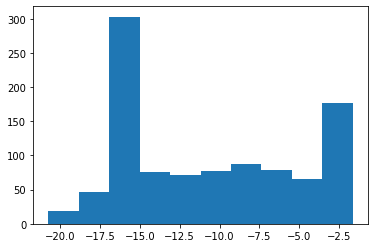

In [59]:
plt.hist(np.log(dist + 10e-10))

(array([807.,  35.,  28.,  24.,  25.,  26.,  32.,  17.,   5.,   1.]),
 array([0.        , 0.01909694, 0.03819387, 0.05729081, 0.07638775,
        0.09548469, 0.11458163, 0.13367857, 0.1527755 , 0.17187244,
        0.19096938], dtype=float32),
 <BarContainer object of 10 artists>)

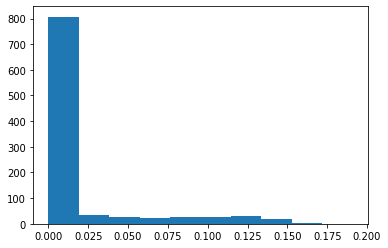

In [60]:
plt.hist(dist)

In [61]:
torch.sort(u @ orig_actions)

torch.return_types.sort(
values=tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        

In [62]:
not_crazy = [d < 0.3 for d in dist]
normal_dist = dist[not_crazy]
normal_x = dataset[not_crazy]

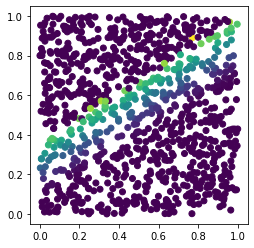

In [63]:
plt.gca().set_aspect('equal')
plt.scatter(normal_x[:,0], normal_x[:,1], c=normal_dist.detach().numpy())

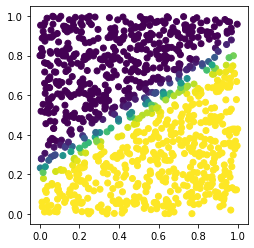

In [64]:
plt.gca().set_aspect('equal')
# plt.scatter(normal_x[:,0], normal_x[:,1], c=normal_dist.detach().numpy())
plt.scatter(normal_x[:,0], normal_x[:,1], c=(u @ orig_actions[:,not_crazy]).detach())
# plt.scatter(normal_x[:,0], normal_x[:,1], c=actions_clf[not_crazy])

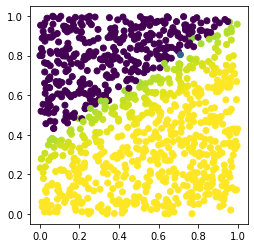

In [65]:
plt.gca().set_aspect('equal')
plt.scatter(normal_x[:,0], normal_x[:,1], c=(u @ actions[:,not_crazy]).detach())

[0.20008014142513275, 0.5498701333999634, 1.0] tensor(0.1000) tensor(0.1000) tensor(0.0002) tensor(1.1645e-08)


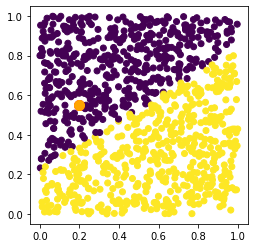

In [72]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=[a[0] > a[1] for a in orig_actions.T])
x_new = torch.tensor([0.2, 0.55, 1])
x_prime = double_gragent(x_new, phi, u, attempts=1, iters=500).detach()
print(x_prime.tolist(), # the moved point
      u @ classify(x_new, phi), # original reward
      u @ classify(x_prime, phi) - 0.5 * torch.norm(x_new - x_prime) ** 2, # new reward
      torch.norm(x_new - x_prime), # distance moved
      0.5 * torch.norm(x_new - x_prime) ** 2) # loss due to distance moved
plt.plot(x_new[0], x_new[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(x_prime[0], x_prime[1], marker="o", markersize=10, markeredgecolor="orange", markerfacecolor="orange")

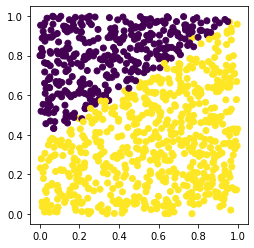

In [67]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=[a[0] > a[1] for a in actions.T])

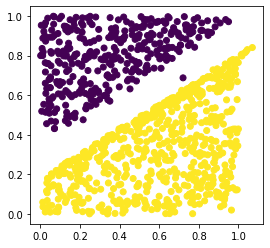

In [68]:
plt.gca().set_aspect('equal')
x_hat = x_hat.detach()
plt.scatter(x_hat[:,0], x_hat[:,1], c=[a[0] > a[1] for a in actions.T])